# Inaugural Project

### Group peter_kj

Imports and set magics:

In [7]:
import numpy as np

# autoreload modules when code is run. Otherwise, python will not see recent changes. 
%load_ext autoreload
%autoreload 2

# Import your own code
import inauguralproject as code

#Importing
from types import SimpleNamespace

import numpy as np
from scipy import optimize

import pandas as pd 
import matplotlib.pyplot as plt
import math


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Class and functions used throughout. Under each question, the functions used are referred to.**

In [8]:
# # code for solving the model (remember documentation and comments)

#Setting up class
class HouseHoldClass1:

    def __init__(self, alpha=0.5, sigma=1.0, wF=1.0):

        #Create namespaces:
        par = self.par = SimpleNamespace()
        sol = self.sol = SimpleNamespace()

    #Setting up parameter values for question 1:

        #Basic preferences:
        par.rho = 2.0
        par.nu = 0.001
        par.epsilon = 1.0
        par.omega = 0.5

        # #Household production: (Baseline values defined in init function)
        par.alpha = alpha
        par.sigma = sigma

        #wages:
        par.wM = 1.0
        par.wF = wF
        par.wF_vec = np.linspace(0.8,1.2,5)

        #targets:
        par.beta0_target = 0.4
        par.beta1_target = -0.1


        # f. solution
        sol.LM_vec = np.zeros(par.wF_vec.size)
        sol.HM_vec = np.zeros(par.wF_vec.size)
        sol.LF_vec = np.zeros(par.wF_vec.size)
        sol.HF_vec = np.zeros(par.wF_vec.size)

        sol.beta0 = np.nan
        sol.beta1 = np.nan


#Utility function 
    def calc_utility(self,LM,HM,LF,HF):
        """ calculate utility """

        par = self.par
        sol = self.sol

        #Defining consumption of market goods:
        C = par.wM*LM + par.wF*LF

        #Defining home production:
        if par.sigma == 0:
            H = np.minimum(HM,HF)
        elif par.sigma == 1.0:
            H = HM**(1.0-par.alpha) * HF**(par.alpha)
        else:
            H = ((1.0-par.alpha)*HM**((par.sigma-1.0)/par.sigma) + par.alpha * HF**((par.sigma-1)/par.sigma))**(par.sigma/(par.sigma-1.0))

        #Defining total consumption:
        Q = C**(par.omega) * H**(1-par.omega)

        #Defining utility, disutility and constraints of max problem:
        #a: utility:
        utility = np.fmax(Q,1e-8)**(1-par.rho) / (1-par.rho)

        #b: disutility and constraints:
        #For convenience, we set epsilon_ to the whole denominator isince brackets of disutility
        epsilon_ = 1 + 1/par.epsilon
        TM = LM + HM
        TF = LF + HF
        disutility = par.nu*(TM**epsilon_/epsilon_ + TF**epsilon_/epsilon_)

        #functions should return final utility:
        return utility - disutility
    

    def solve_discrete(self,do_print=False):
        """ solve model discretely """
        
        par = self.par
        sol = self.sol
        opt = SimpleNamespace()
        
        # a. all possible choices
        x = np.linspace(0,24,49)
        LM,HM,LF,HF = np.meshgrid(x,x,x,x) # all combinations
    
        LM = LM.ravel() # vector
        HM = HM.ravel()
        LF = LF.ravel()
        HF = HF.ravel()

        # b. calculate utility
        u = self.calc_utility(LM,HM,LF,HF)
    
        # c. set to minus infinity if constraint is broken
        I = (LM+HM > 24) | (LF+HF > 24) # | is "or"
        u[I] = -np.inf
    
        # d. find maximizing argument
        j = np.argmax(u)
        
        opt.LM = LM[j]
        opt.HM = HM[j]
        opt.LF = LF[j]
        opt.HF = HF[j]

        # e. print
        if do_print:
            for k,v in opt.__dict__.items():
                print(f'{k} = {v:6.4f}')

        return opt
    



   

    def solve(self,do_print=False):
        """ solve model continously """
        
        par = self.par
        sol = self.sol
        opt = SimpleNamespace()
        

        #x0:LM, x1:HM, x2:LF, x3:HF 

        #constraints and bounds
        
        obj = lambda x: -self.calc_utility(x[0], x[1], x[2], x[3])
        constraint1 = lambda x: 24 - x[0] - x[1]
        constraint2 = lambda x: 24 - x[2] - x[3]
        #constraint3 = lambda x: 
        constraints = ({'type': 'ineq', 'fun':constraint1, 'fun':constraint2})
        bounds = ((1e-8,24), (1e-8,24), (1e-8,24), (1e-8,24))

        
        #Guessing on 4 hours spent on home work and market work for both genders
        x0 = [4,4,4,4]
        #call solver
        result = optimize.minimize(obj, x0, method='SLSQP', bounds=bounds, constraints=constraints)


        # sol.x1 = result.x[0]
        # sol.x2 = result.x[1]
        # sol.x3 = result.x[2]
        # sol.x4 = result.x[3]

        opt.LM = result.x[0]
        opt.HM = result.x[1]
        opt.LF = result.x[2]
        opt.HF = result.x[3]

        return opt
          

    def solve_wF_vec(self,discrete=False):
        """ solve model for vector of female wages """
                
        par = self.par
        sol = self.sol
        
        #Running continuous solve with baseline values for each of the 5 wF values:
        i=0
        while i<5:
            for par.wF in par.wF_vec:
                sol.HF_vec[i] = self.solve().HF
                sol.HM_vec[i] = self.solve().HM
                sol.LF_vec[i] = self.solve().LF
                sol.LM_vec[i] = self.solve().LM
                i=i+1
    
        return sol
        

    def run_regression(self):
        """ run regression """

        par = self.par
        sol = self.sol

        x = np.log(par.wF_vec)
        #y = np.log(sol.HF_vec/sol.HM_vec)
        y = np.log(self.solve_wF_vec().HF_vec/self.solve_wF_vec().HM_vec)
        A = np.vstack([np.ones(x.size),x]).T
        sol.beta0,sol.beta1 = np.linalg.lstsq(A,y,rcond=None)[0]

    
        return sol
    


# Question 1

I changed the alpha and sigma parameters in the __init__ function, such that different values can be given as input when running an instance of the class. If none is given, the baseline values are used.

I solve the question by pre-allocating a 3x3 matrix.

I then use nested for loops to run and instance of the class for each of the 9 combinations of sigma and alpha. I use while loops to allocate the output of HF/HM to the right indexes in the matrix.

I then use the tabulate package to put the results in a table with row and column names. Hence, install the below package before running. If you are unable to install, then just comment it out together with the last two lines of the code.

Conclusion is that:
- When alpha = 0.25 then the HF/HM ratio have negative relationship with sigma.
- When alpha = 0.5 then the HF/HM ratio doesn't change with sigma.
- When alpha = 0.75 then the HF/HM ratio have a positive relationship with sigma.

In [9]:
#IF U HAVE NOT INSTALLED TABULATE, THIS NEEDS TO BE DONE TO SHOW THE RESULTS NICELY
#If you are unable to install, then just comment it out together with the last two lines of the code.
!pip install tabulate
from tabulate import tabulate

In [10]:
#CODE SECTION

#Creating array for HF/HM values:

HF_HM_ratio = np.empty((3,3))

#Looping over the values:

#Setting count:
count = 0
i=0
while i<len(HF_HM_ratio):  
    for alpha in [0.25, 0.50, 0.75]:
        j=0
        while j<len(HF_HM_ratio):
            for sigma in [0.5, 1.0, 1.5]:
                print('alpha:', alpha)
                print('sigma:', sigma)
                #print(i)
                #print(j)
                inst1 = HouseHoldClass1(alpha=alpha, sigma=sigma)
                HF_HM_ratio[i,j]=inst1.solve_discrete().HF/inst1.solve_discrete().HM
                print('HF/HM:', inst1.solve_discrete().HF/inst1.solve_discrete().HM)
                print('__________________')
                count = count + 1
                j=j+1
        i=i+1
            
#Creating illustration
col_names = ['','sigma=0.5', 'sigma=1.0', 'sigma=1.5']
row_names = ['alpha=0.25', 'alpha=0.5', 'alpha=0.75']

#Concatenating row names to the data
illustration = np.c_[row_names, HF_HM_ratio]

#Using imported tabulate function to create table with the row names added
#(Comment out if tabulate not installed)
print('Values of HF/HM for all possible combinations of alpha and sigma')
print(tabulate(illustration, headers=col_names, tablefmt="fancy_grid"))

alpha: 0.25
sigma: 0.5


C:\Users\Peter\AppData\Local\Temp/ipykernel_13652/257951892.py:60: RuntimeWarning: divide by zero encountered in reciprocal
  H = ((1.0-par.alpha)*HM**((par.sigma-1.0)/par.sigma) + par.alpha * HF**((par.sigma-1)/par.sigma))**(par.sigma/(par.sigma-1.0))


HF/HM: 0.5454545454545454
__________________
alpha: 0.25
sigma: 1.0
HF/HM: 0.3076923076923077
__________________
alpha: 0.25
sigma: 1.5
HF/HM: 0.21428571428571427
__________________
alpha: 0.5
sigma: 0.5


KeyboardInterrupt: 

# Question 2

I have changed the input in the __init__ function, such that female wage can be given as an input. If none is given, it still uses the baseline value. The baseline male wage is used.

I create a vector of the 5 different values of female wage.
I then run the solve_discrete function 5 times, with the 5 different values of wF. I do this by pre-allocating vectors for the HF/HM and wF/wM results, and then running a loop that puts the outputs in each vector, which is then plotted.

The conclusion is that there is a clear negative relationship between female wage and the ratio between female and male home-working hours. A low female wage indicates that the female works relatively more from home than the male, and vice versa. 

Text(0, 0.5, 'log(HF/HM)')

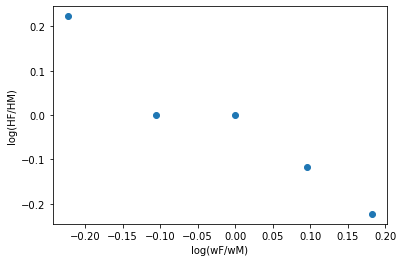

In [ ]:
#Defining vector of wF values:
wF_vec = np.linspace(0.8,1.2,5)

#Initializing x and y for plot:
HF_HM_ratio = np.empty(5)
log_wF_wM_ratio = np.empty(5)

#Running discrete solve with baseline values for each of the 5 wF values:
count=0
i=0
while i<5:
    for wF in wF_vec:
        inst2 = HouseHoldClass1(wF=wF)
        HF_HM_ratio[i] = np.log(inst2.solve_discrete().HF/inst2.solve_discrete().HM)
        log_wF_wM_ratio[i] = np.log(wF/1)
        i=i+1

#print(HF_HM_ratio)
#print(log_wF_wH_ratio)

plt.plot(log_wF_wM_ratio, HF_HM_ratio, 'o')
plt.xlabel('log(wF/wM)')
plt.ylabel('log(HF/HM)')


# Question 3

I have added a __solve__ function in the 'class and function' section to solve the model continously. I use scipy.optimize.minimize on the variables LM, LF, HM and HF. I do this by setting up and objective function, which is the calc_utility. I then optimize this with the SLSQP method, with constraints LM+HM<24 and LF+HF<24. I use the bounds (LM, HM, LF, HF) $\in$ [0,24]. Futhermore, I have added a __solve_wF_vec__ function that solves the model continously for all the values in wF_vec and assigns the results to the solution vectors in the __init__ function.

I then plot the results.

We can conclude that there now is a minor negative relationship between female wage and the ratio of female to male home-working hours. To compare with question 2, we can see that the ratio of wF/wM now only changes the optimal ratio of HF/HM for the two most extreme values of wF.

Text(0, 0.5, 'log(HF/HM)')

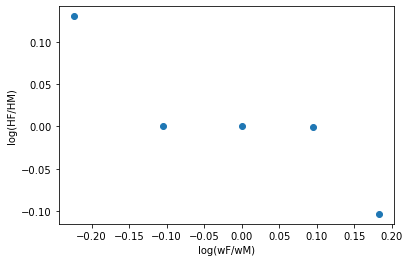

In [ ]:
#Using the 
inst3 = HouseHoldClass1(sigma=1)
wF_vec=[0.8,0.9,1.0,1.1,1.2]
plt.plot(np.log(wF_vec), np.log(inst3.solve_wF_vec().HF_vec/inst3.solve_wF_vec().HM_vec), 'o')
plt.xlabel('log(wF/wM)')
plt.ylabel('log(HF/HM)')


# Question 4

I solve this question by looping through 50 combinations of alpha and sigma, specified below. For each combination, and instance of the main class is run with the function __run_regression__. Then the calculated coeffecients are used to calculate the sum of squared differences. All output is appended in the 3 pre-allocated lists, and finally argmin is used on the vector of squared difference sums, to find the index of the minimum one. This index is used to to show what values of alpha and sigma led to the minimized sum.

In [ ]:
#Setting intervals for alpha and sigma
alpha_int = np.linspace(0.1,1.0,10)
sigma_int = np.array([0.1, 0.5, 1.0, 1.5, 2.0])
print('I will try all combinations of alpha=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.] and sigma=[0.1, 0.5, 1.0, 1.5, 2.0]')
#Pre-allocating lists for output
alpha_output = []
sigma_output = []
squared_diff_output = []

#Running nested loop for all combinations of alpha and sigma. 
#It runs the the regression for the class with the given parameters, calculates the sum of squared diff'set
#and appends the results to the 3 lists

for alpha in alpha_int:
    for sigma in sigma_int:
        inst5 = HouseHoldClass1(alpha=alpha, sigma=sigma, wF=1.0).run_regression()
        squared_diff = (0.4-inst5.beta0)**2 + (-0.1 - inst5.beta1)**2
        # print(f"alpha: {alpha}")
        # print(f"sigma: {sigma}")
        # print(f"squared diff: {squared_diff}")
        # print("________________")
        alpha_output.append(alpha)
        sigma_output.append(sigma)
        squared_diff_output.append(squared_diff)

#Printing the results by using argmin on squared_diff_output and using the resulting index to find the optimal alpha and sigma
print(f"The minimized sum of squared differences is {squared_diff_output[np.argmin(squared_diff_output)]} with alpha={alpha_output[np.argmin(squared_diff_output)]} and sigma={sigma_output[np.argmin(squared_diff_output)]}")



I will try all combinations of alpha=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.] and sigma=[0.1, 0.5, 1.0, 1.5, 2.0]


c:\Users\Peter\anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


The minimized sum of squared differences is 0.033105315420753456 with alpha=0.9 and sigma=0.1


Having found the optimal values of alpha in sigma, in order to minimize the sum squared beta-diff's, that is, we now extract the data by running the class with the optimal alpha and sigma parameters. I do this by solving the model for all the values of wF and save solution HF and HM vectors. I then extract the beta0 and beta1, so that I can calculate log(HF/HM) = beta0 + beta1*log(wF/wM). I plot the solution log(HF/HM) and the one calculated by the beta-coeffecients against log(wF/wM).

In conclusion, we see that the estimated beta-coefficients gives a relatively good fit to the data. THere is a clear negative relationship between female wage and the ratio of female to male home-working hours. This makes intuitive sense, since an individual earning a high wage will obviously be more incentivized to spend time in the labor market.

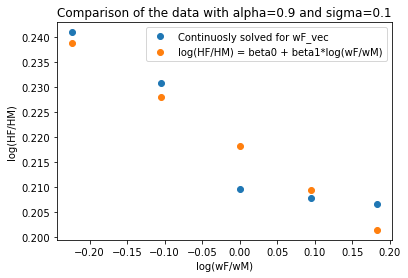

In [ ]:
#We found optimal choices of alpha=0.9 and sigma = 0.1. 
#I will now solve the model for all the values of wF and plot log(wF/wM) against log(HF/HM)
inst6 = HouseHoldClass1(alpha=0.9, sigma=0.1).solve_wF_vec()
x1 = np.log(wF_vec)
y1 = np.log(inst6.HF_vec/inst6.HM_vec)


#I now retrieve beta0 and beta1 from running regression with optimal alpha and sigma.
#I then use these together with wF to calculate log(HF/HM) and compare the results.
inst7 = HouseHoldClass1(alpha=0.9, sigma=0.1).run_regression()
beta0=inst7.beta0
beta1=inst7.beta1
x2 = np.log(wF_vec)
y2 = beta0 + beta1*np.log(wF_vec)

#Plotting
plt.plot(x1,y1,'o',label='Continuosly solved for wF_vec')
plt.plot(x2,y2,'o', label="log(HF/HM) = beta0 + beta1*log(wF/wM)")
plt.xlabel("log(wF/wM)")
plt.ylabel("log(HF/HM)")
plt.title("Comparison of the data with alpha=0.9 and sigma=0.1")
plt.legend()






# Question 5